In [2]:
import numpy as np
from glob import glob
import os
from PIL import Image
import cv2
from tqdm import tqdm

images = glob("./train/images/*.jpg")

masked_imgs = list()
sliced_images = list()

for image in tqdm(images, total=len(images)):
  fname = os.path.basename(image)
  label = "./train/labels/"+fname[:-4]+".txt"
  image = np.array(Image.open(image))
  sliced_images.append(image)
  width, height, _ = image.shape

  mask = np.zeros((width, height), dtype=np.uint8)

  segmentations = list()
  bboxes = list()
  with open(label) as f:
    for line in f:
      coords = line.split(" ")
      x_coords = [int(float(coord) * width) for i, coord in enumerate(coords) if i % 2 != 0]
      y_coords = [int(float(coord) * height) for i, coord in enumerate(coords) if i % 2 == 0]
      del y_coords[0]

      segmentation = list(zip(x_coords, y_coords))
      segmentations.append(np.array(segmentation))
      bbox = [min(x_coords), min(y_coords), max(x_coords), max(y_coords)]
      bboxes.append(bbox)

      #sliced_images.append(image[bbox[1]:bbox[3], bbox[0]:bbox[2], :])

  mask = cv2.fillPoly(mask, segmentations, 1)

  masked_img1 = mask * image[:, :, 0]
  masked_img2 = mask * image[:, :, 1]
  masked_img3 = mask * image[:, :, 2]
  masked_img = cv2.merge((masked_img1, masked_img2, masked_img3))
  masked_imgs.append(masked_img)

100%|██████████| 172/172 [00:02<00:00, 77.32it/s]


In [3]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms

In [4]:
train_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation((-20, 20)),
    transforms.ToTensor(),
])

test_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

class MyDataset(Dataset):
    def __init__(self, images, transform=None):
        self.images = images
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = Image.fromarray(self.images[idx])
        if self.transform is not None:
            image = self.transform(image)

        return image, 0

batch_size = 16

train_dataset = MyDataset(sliced_images[:int(len(sliced_images) * 1)], transform=train_transform)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# test_dataset = MyDataset(masked_imgs[int(len(masked_imgs) * 0.8):], transform=test_transform)
# test_dataloader = DataLoader(test_dataset, batch_size=batch_size // 8, shuffle=False)

# FC AutoEncoder

In [68]:
import torch.nn as nn

class Autoencoder(nn.Module):
    def __init__(self, latent_dim=128):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            # 3 * 64 * 64 -> 128 -> 64 -> 32 -> 16 -> 8 -> 4 -> 2 -> 1  ( 3 layers )
            nn.Linear(3 * 128 * 128, latent_dim*4), nn.ReLU(),
            nn.Linear(latent_dim*4, latent_dim*2), nn.ReLU(),
            nn.Linear(latent_dim*2, latent_dim), nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, latent_dim*2), nn.ReLU(),
            nn.Linear(latent_dim*2, latent_dim*4), nn.ReLU(),
            nn.Linear(latent_dim*4, 3 * 128 * 128), nn.Sigmoid()
        )

    def forward(self, x):
        x = x.view(x.shape[0], -1)
        x = self.encoder(x)
        x = self.decoder(x)
        x = x.view(x.shape[0], 3, 128, 128)
        return x

In [178]:
import torch

epochs = 50

ae = Autoencoder(latent_dim=512).to('cuda')
optimizer = torch.optim.Adam(ae.parameters(), lr=3e-4)
criterion = nn.MSELoss()

for epoch in range(epochs):
  print(f"epoch : {epoch+1}")
  for data in tqdm(train_dataloader, total=len(train_dataloader)):
    images, _ = data
    images = images.to('cuda')
    reconstructed = ae(images)

    loss = criterion(reconstructed, images)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  print("train loss : ", loss.item())

  # for data in tqdm(test_dataloader, total=len(test_dataloader)):
  #   images, _ = data
  #   images = images.to('cuda')
  #   reconstructed = ae(images)

  #   loss = criterion(reconstructed, images)

  # print("test loss : ", loss.item())

epoch : 1


100%|██████████| 11/11 [00:00<00:00, 15.95it/s]


train loss :  0.043412674218416214
epoch : 2


100%|██████████| 11/11 [00:00<00:00, 16.60it/s]


train loss :  0.03556631878018379
epoch : 3


100%|██████████| 11/11 [00:00<00:00, 18.34it/s]


train loss :  0.03770669177174568
epoch : 4


100%|██████████| 11/11 [00:00<00:00, 23.99it/s]


train loss :  0.03843221068382263
epoch : 5


100%|██████████| 11/11 [00:00<00:00, 23.43it/s]


train loss :  0.03628172352910042
epoch : 6


100%|██████████| 11/11 [00:00<00:00, 22.12it/s]


train loss :  0.03223767504096031
epoch : 7


100%|██████████| 11/11 [00:00<00:00, 11.51it/s]


train loss :  0.032114870846271515
epoch : 8


100%|██████████| 11/11 [00:00<00:00, 12.08it/s]


train loss :  0.03878353163599968
epoch : 9


100%|██████████| 11/11 [00:00<00:00, 20.41it/s]


train loss :  0.02756301499903202
epoch : 10


100%|██████████| 11/11 [00:00<00:00, 24.77it/s]


train loss :  0.02636224776506424
epoch : 11


100%|██████████| 11/11 [00:00<00:00, 24.28it/s]


train loss :  0.03290236368775368
epoch : 12


100%|██████████| 11/11 [00:00<00:00, 25.46it/s]


train loss :  0.034441519528627396
epoch : 13


100%|██████████| 11/11 [00:00<00:00, 24.57it/s]


train loss :  0.029371483251452446
epoch : 14


100%|██████████| 11/11 [00:00<00:00, 24.96it/s]


train loss :  0.028958899900317192
epoch : 15


100%|██████████| 11/11 [00:00<00:00, 24.44it/s]


train loss :  0.03148556873202324
epoch : 16


100%|██████████| 11/11 [00:00<00:00, 25.33it/s]


train loss :  0.025690801441669464
epoch : 17


100%|██████████| 11/11 [00:00<00:00, 25.16it/s]


train loss :  0.02776290476322174
epoch : 18


100%|██████████| 11/11 [00:00<00:00, 24.17it/s]


train loss :  0.025004740804433823
epoch : 19


100%|██████████| 11/11 [00:00<00:00, 25.36it/s]


train loss :  0.03142218291759491
epoch : 20


100%|██████████| 11/11 [00:00<00:00, 24.60it/s]


train loss :  0.022406751289963722
epoch : 21


100%|██████████| 11/11 [00:00<00:00, 25.67it/s]


train loss :  0.024217359721660614
epoch : 22


100%|██████████| 11/11 [00:00<00:00, 18.84it/s]


train loss :  0.02111547626554966
epoch : 23


100%|██████████| 11/11 [00:00<00:00, 16.54it/s]


train loss :  0.03704669326543808
epoch : 24


100%|██████████| 11/11 [00:00<00:00, 15.70it/s]


train loss :  0.030685927718877792
epoch : 25


100%|██████████| 11/11 [00:00<00:00, 15.89it/s]


train loss :  0.021277999505400658
epoch : 26


100%|██████████| 11/11 [00:00<00:00, 16.21it/s]


train loss :  0.02242336980998516
epoch : 27


100%|██████████| 11/11 [00:00<00:00, 16.07it/s]


train loss :  0.021894268691539764
epoch : 28


100%|██████████| 11/11 [00:00<00:00, 16.12it/s]


train loss :  0.022866133600473404
epoch : 29


100%|██████████| 11/11 [00:00<00:00, 18.55it/s]


train loss :  0.023252543061971664
epoch : 30


100%|██████████| 11/11 [00:00<00:00, 24.61it/s]


train loss :  0.02385200932621956
epoch : 31


100%|██████████| 11/11 [00:00<00:00, 24.55it/s]


train loss :  0.01995949260890484
epoch : 32


100%|██████████| 11/11 [00:00<00:00, 24.70it/s]


train loss :  0.02021774649620056
epoch : 33


100%|██████████| 11/11 [00:00<00:00, 24.74it/s]


train loss :  0.0241355262696743
epoch : 34


100%|██████████| 11/11 [00:00<00:00, 24.95it/s]


train loss :  0.023937344551086426
epoch : 35


100%|██████████| 11/11 [00:00<00:00, 24.63it/s]


train loss :  0.02190488576889038
epoch : 36


100%|██████████| 11/11 [00:00<00:00, 24.83it/s]


train loss :  0.020057247951626778
epoch : 37


100%|██████████| 11/11 [00:00<00:00, 25.45it/s]


train loss :  0.024858051910996437
epoch : 38


100%|██████████| 11/11 [00:00<00:00, 24.62it/s]


train loss :  0.021014105528593063
epoch : 39


100%|██████████| 11/11 [00:00<00:00, 24.74it/s]


train loss :  0.023123787716031075
epoch : 40


100%|██████████| 11/11 [00:00<00:00, 25.65it/s]


train loss :  0.021199163049459457
epoch : 41


100%|██████████| 11/11 [00:00<00:00, 24.92it/s]


train loss :  0.01918262429535389
epoch : 42


100%|██████████| 11/11 [00:00<00:00, 24.99it/s]


train loss :  0.02209356799721718
epoch : 43


100%|██████████| 11/11 [00:00<00:00, 25.07it/s]


train loss :  0.02034115605056286
epoch : 44


100%|██████████| 11/11 [00:00<00:00, 25.87it/s]


train loss :  0.025087995454669
epoch : 45


100%|██████████| 11/11 [00:00<00:00, 26.08it/s]


train loss :  0.01851748116314411
epoch : 46


100%|██████████| 11/11 [00:00<00:00, 25.45it/s]


train loss :  0.024478647857904434
epoch : 47


100%|██████████| 11/11 [00:00<00:00, 25.48it/s]


train loss :  0.02527805045247078
epoch : 48


100%|██████████| 11/11 [00:00<00:00, 24.81it/s]


train loss :  0.018268078565597534
epoch : 49


100%|██████████| 11/11 [00:00<00:00, 24.60it/s]


train loss :  0.02251838520169258
epoch : 50


100%|██████████| 11/11 [00:00<00:00, 23.71it/s]

train loss :  0.017062846571207047


In [179]:
import time
sample = test_transform(Image.fromarray(sliced_images[1])).reshape(1, 3, 128, 128).to('cuda')
ae.eval()
start = time.time()
reconstructed = ae(sample)
print(time.time()-start)

0.003068685531616211


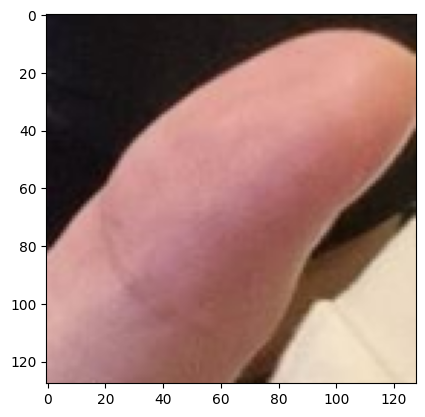

In [180]:
import matplotlib.pyplot as plt

plt.imshow(sample[0].permute(1, 2, 0).detach().cpu())

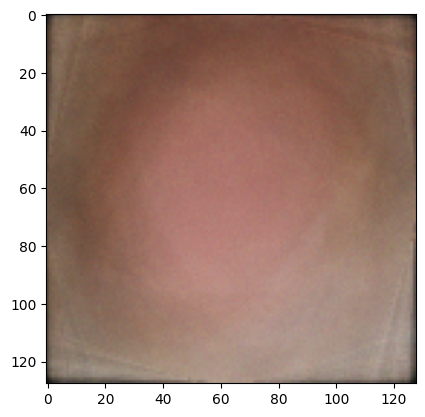

In [181]:
plt.imshow(reconstructed[0].permute(1, 2, 0).detach().cpu())

# Conv AutoEncoder

In [73]:
class Encoder(nn.Module):
    def __init__(self, latent_dim):
        super(Encoder, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.linear = nn.Linear(128 * 32 * 32, latent_dim)

    def forward(self, x):
        x = nn.functional.relu(self.conv1(x))
        x = nn.functional.max_pool2d(x, 2)
        x = nn.functional.relu(self.conv2(x))
        x = nn.functional.max_pool2d(x, 2)
        x = nn.functional.relu(self.conv3(x))
        x = x.view(-1, 128 * 32 * 32)
        x = self.linear(x)
        return x

class Decoder(nn.Module):
    def __init__(self, latent_dim):
        super(Decoder, self).__init__()
        self.linear = nn.Linear(latent_dim, 128 * 32 * 32)
        self.conv1 = nn.ConvTranspose2d(128, 64, kernel_size=3, padding=1)
        self.conv2 = nn.ConvTranspose2d(64, 32, kernel_size=3, padding=1)
        self.conv3 = nn.ConvTranspose2d(32, 3, kernel_size=3, padding=1)

    def forward(self, z):
        x = self.linear(z).view(-1, 128, 32, 32)
        x = nn.functional.relu(self.conv1(x))
        x = nn.functional.interpolate(x, scale_factor=2)
        x = nn.functional.relu(self.conv2(x))
        x = nn.functional.interpolate(x, scale_factor=2)
        x = nn.functional.sigmoid(self.conv3(x))
        return x

class ConvAutoencoder(nn.Module):
  def __init__(self, latent_dim):
    super(ConvAutoencoder, self).__init__()
    self.encoder = Encoder(latent_dim)
    self.decoder = Decoder(latent_dim)

  def forward(self, x):
    z = self.encoder(x)
    reconstructed = self.decoder(z)
    return reconstructed

In [182]:
import torch

epochs = 20

cae = ConvAutoencoder(latent_dim=512).to('cuda')
optimizer = torch.optim.Adam(cae.parameters(), lr=3e-4)
criterion = nn.MSELoss()

for epoch in range(epochs):
  print(f"epoch : {epoch+1}")
  for data in tqdm(train_dataloader, total=len(train_dataloader)):
    images, _ = data
    images = images.to('cuda')
    reconstructed = cae(images)

    loss = criterion(reconstructed, images)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  print("train loss : ", loss.item())

epoch : 1


100%|██████████| 11/11 [00:00<00:00, 15.50it/s]


train loss :  0.04118998721241951
epoch : 2


100%|██████████| 11/11 [00:00<00:00, 15.78it/s]


train loss :  0.0407918319106102
epoch : 3


100%|██████████| 11/11 [00:00<00:00, 15.69it/s]


train loss :  0.03551362082362175
epoch : 4


100%|██████████| 11/11 [00:00<00:00, 20.24it/s]


train loss :  0.022909289225935936
epoch : 5


100%|██████████| 11/11 [00:00<00:00, 23.40it/s]


train loss :  0.0201173797249794
epoch : 6


100%|██████████| 11/11 [00:00<00:00, 24.44it/s]


train loss :  0.017678823322057724
epoch : 7


100%|██████████| 11/11 [00:00<00:00, 23.43it/s]


train loss :  0.014812830835580826
epoch : 8


100%|██████████| 11/11 [00:00<00:00, 25.21it/s]


train loss :  0.013015036471188068
epoch : 9


100%|██████████| 11/11 [00:00<00:00, 23.88it/s]


train loss :  0.012414357624948025
epoch : 10


100%|██████████| 11/11 [00:00<00:00, 25.59it/s]


train loss :  0.010998144745826721
epoch : 11


100%|██████████| 11/11 [00:00<00:00, 23.15it/s]


train loss :  0.012994945980608463
epoch : 12


100%|██████████| 11/11 [00:00<00:00, 24.99it/s]


train loss :  0.009901607409119606
epoch : 13


100%|██████████| 11/11 [00:00<00:00, 25.05it/s]


train loss :  0.011681209318339825
epoch : 14


100%|██████████| 11/11 [00:00<00:00, 25.57it/s]


train loss :  0.010297165252268314
epoch : 15


100%|██████████| 11/11 [00:00<00:00, 25.31it/s]


train loss :  0.009414523839950562
epoch : 16


100%|██████████| 11/11 [00:00<00:00, 24.59it/s]


train loss :  0.012016472406685352
epoch : 17


100%|██████████| 11/11 [00:00<00:00, 25.45it/s]


train loss :  0.010127244517207146
epoch : 18


100%|██████████| 11/11 [00:00<00:00, 24.67it/s]


train loss :  0.008316656574606895
epoch : 19


100%|██████████| 11/11 [00:00<00:00, 25.66it/s]


train loss :  0.008196537382900715
epoch : 20


100%|██████████| 11/11 [00:00<00:00, 24.93it/s]

train loss :  0.008222980424761772


In [183]:
import time
sample = test_transform(Image.fromarray(sliced_images[1])).reshape(1, 3, 128, 128).to('cuda')
cae.eval()
start = time.time()
reconstructed = cae(sample)
print(time.time()-start)

0.003651142120361328


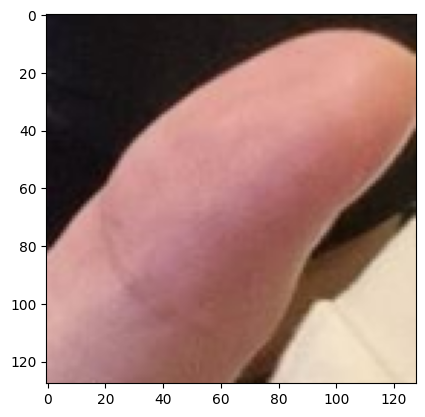

In [184]:
import matplotlib.pyplot as plt

plt.imshow(sample[0].permute(1, 2, 0).detach().cpu())

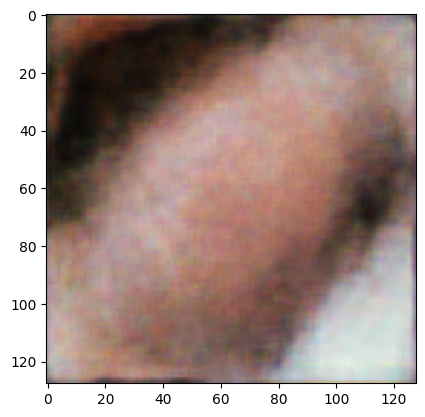

In [185]:
plt.imshow(reconstructed[0].permute(1, 2, 0).detach().cpu())

# UNet

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=3):
        super(UNet, self).__init__()

        # Encoder
        self.conv1 = nn.Conv2d(in_channels, 64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv5 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.conv6 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv7 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.conv8 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.drop4 = nn.Dropout2d(0.5)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Bottleneck
        self.conv9 = nn.Conv2d(512, 1024, kernel_size=3, padding=1)
        self.conv10 = nn.Conv2d(1024, 1024, kernel_size=3, padding=1)
        self.drop5 = nn.Dropout2d(0.5)

        # Decoder
        self.up6 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.conv11 = nn.Conv2d(1024, 512, kernel_size=3, padding=1)
        self.conv12 = nn.Conv2d(512, 512, kernel_size=3, padding=1)

        self.up7 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.conv13 = nn.Conv2d(512, 256, kernel_size=3, padding=1)
        self.conv14 = nn.Conv2d(256, 256, kernel_size=3, padding=1)

        self.up8 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.conv15 = nn.Conv2d(256, 128, kernel_size=3, padding=1)
        self.conv16 = nn.Conv2d(128, 128, kernel_size=3, padding=1)

        self.up9 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.conv17 = nn.Conv2d(128, 64, kernel_size=3, padding=1)
        self.conv18 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.conv19 = nn.Conv2d(64, 16, kernel_size=3, padding=1)

        self.conv20 = nn.Conv2d(16, out_channels, kernel_size=1)

    def forward(self, x):
        # Encoder
        conv1 = F.relu(self.conv1(x))
        conv1 = F.relu(self.conv2(conv1))
        pool1 = self.pool1(conv1)

        conv2 = F.relu(self.conv3(pool1))
        conv2 = F.relu(self.conv4(conv2))
        pool2 = self.pool2(conv2)

        conv3 = F.relu(self.conv5(pool2))
        conv3 = F.relu(self.conv6(conv3))
        pool3 = self.pool3(conv3)

        conv4 = F.relu(self.conv7(pool3))
        conv4 = F.relu(self.conv8(conv4))
        drop4 = self.drop4(conv4)
        pool4 = self.pool4(drop4)

        # Bottleneck
        conv5 = F.relu(self.conv9(pool4))
        conv5 = F.relu(self.conv10(conv5))
        drop5 = self.drop5(conv5)

        # Decoder
        up6 = self.up6(drop5)
        merge6 = torch.cat([drop4, up6], dim=1)
        conv6 = F.relu(self.conv11(merge6))
        conv6 = F.relu(self.conv12(conv6))

        up7 = self.up7(conv6)
        merge7 = torch.cat([conv3, up7], dim=1)
        conv7 = F.relu(self.conv13(merge7))
        conv7 = F.relu(self.conv14(conv7))

        up8 = self.up8(conv7)
        merge8 = torch.cat([conv2, up8], dim=1)
        conv8 = F.relu(self.conv15(merge8))
        conv8 = F.relu(self.conv16(conv8))

        up9 = self.up9(conv8)
        merge9 = torch.cat([conv1, up9], dim=1)
        conv9 = F.relu(self.conv17(merge9))
        conv9 = F.relu(self.conv18(conv9))
        conv9 = F.relu(self.conv19(conv9))

        conv10 = torch.sigmoid(self.conv20(conv9))

        return conv10

In [6]:
def identity_loss(y_true, y_pred):
    loss = torch.mean(torch.abs(y_true - y_pred))
    return loss

In [7]:
import torch

epochs = 100

input_size = (3, 128, 128)  # Assuming input channels, height, and width

unet = UNet(in_channels=input_size[0]).to('cuda')
optimizer = torch.optim.Adam(unet.parameters(), lr=3e-4)
criterion = nn.MSELoss()


for epoch in range(epochs):
  print(f"epoch : {epoch+1}")
  for data in tqdm(train_dataloader, total=len(train_dataloader)):
    images, _ = data
    images = images.to('cuda')
    reconstructed = unet(images)

    loss = identity_loss(reconstructed, images)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  print("train loss : ", loss.item())

epoch : 1


100%|██████████| 11/11 [00:03<00:00,  3.66it/s]


train loss :  0.20185795426368713
epoch : 2


100%|██████████| 11/11 [00:01<00:00,  5.92it/s]


train loss :  0.1705281138420105
epoch : 3


100%|██████████| 11/11 [00:02<00:00,  5.06it/s]


train loss :  0.15247370302677155
epoch : 4


100%|██████████| 11/11 [00:01<00:00,  8.69it/s]


train loss :  0.11108586937189102
epoch : 5


100%|██████████| 11/11 [00:00<00:00, 11.09it/s]


train loss :  0.1151169165968895
epoch : 6


100%|██████████| 11/11 [00:01<00:00,  7.77it/s]


train loss :  0.08624480664730072
epoch : 7


100%|██████████| 11/11 [00:01<00:00, 10.32it/s]


train loss :  0.0544697567820549
epoch : 8


100%|██████████| 11/11 [00:00<00:00, 14.44it/s]


train loss :  0.04485868662595749
epoch : 9


100%|██████████| 11/11 [00:00<00:00, 16.38it/s]


train loss :  0.03607211261987686
epoch : 10


100%|██████████| 11/11 [00:00<00:00, 16.74it/s]


train loss :  0.033640433102846146
epoch : 11


100%|██████████| 11/11 [00:00<00:00, 16.58it/s]


train loss :  0.026671279221773148
epoch : 12


100%|██████████| 11/11 [00:00<00:00, 16.48it/s]


train loss :  0.031050248071551323
epoch : 13


100%|██████████| 11/11 [00:00<00:00, 16.31it/s]


train loss :  0.03664710745215416
epoch : 14


100%|██████████| 11/11 [00:00<00:00, 16.61it/s]


train loss :  0.03207569941878319
epoch : 15


100%|██████████| 11/11 [00:00<00:00, 16.44it/s]


train loss :  0.027722323313355446
epoch : 16


100%|██████████| 11/11 [00:00<00:00, 14.87it/s]


train loss :  0.026317959651350975
epoch : 17


100%|██████████| 11/11 [00:00<00:00, 14.29it/s]


train loss :  0.02289092354476452
epoch : 18


100%|██████████| 11/11 [00:00<00:00, 15.12it/s]


train loss :  0.023029843345284462
epoch : 19


100%|██████████| 11/11 [00:00<00:00, 14.43it/s]


train loss :  0.02060420997440815
epoch : 20


100%|██████████| 11/11 [00:00<00:00, 14.42it/s]


train loss :  0.01808132603764534
epoch : 21


100%|██████████| 11/11 [00:00<00:00, 14.84it/s]


train loss :  0.016592765226960182
epoch : 22


100%|██████████| 11/11 [00:00<00:00, 16.08it/s]


train loss :  0.019659966230392456
epoch : 23


100%|██████████| 11/11 [00:00<00:00, 16.55it/s]


train loss :  0.01922656036913395
epoch : 24


100%|██████████| 11/11 [00:00<00:00, 16.63it/s]


train loss :  0.019542980939149857
epoch : 25


100%|██████████| 11/11 [00:00<00:00, 16.63it/s]


train loss :  0.019098320975899696
epoch : 26


100%|██████████| 11/11 [00:00<00:00, 16.63it/s]


train loss :  0.021378377452492714
epoch : 27


100%|██████████| 11/11 [00:00<00:00, 16.76it/s]


train loss :  0.0169833954423666
epoch : 28


100%|██████████| 11/11 [00:00<00:00, 16.65it/s]


train loss :  0.018602529540657997
epoch : 29


100%|██████████| 11/11 [00:00<00:00, 16.27it/s]


train loss :  0.015992546454072
epoch : 30


100%|██████████| 11/11 [00:00<00:00, 16.64it/s]


train loss :  0.013843455351889133
epoch : 31


100%|██████████| 11/11 [00:00<00:00, 16.51it/s]


train loss :  0.01682782731950283
epoch : 32


100%|██████████| 11/11 [00:00<00:00, 16.62it/s]


train loss :  0.016889452934265137
epoch : 33


100%|██████████| 11/11 [00:00<00:00, 16.63it/s]


train loss :  0.014431840740144253
epoch : 34


100%|██████████| 11/11 [00:00<00:00, 16.52it/s]


train loss :  0.014138772152364254
epoch : 35


100%|██████████| 11/11 [00:00<00:00, 16.61it/s]


train loss :  0.013340311124920845
epoch : 36


100%|██████████| 11/11 [00:00<00:00, 15.58it/s]


train loss :  0.01407188456505537
epoch : 37


100%|██████████| 11/11 [00:00<00:00, 13.87it/s]


train loss :  0.012455269694328308
epoch : 38


100%|██████████| 11/11 [00:00<00:00, 14.20it/s]


train loss :  0.015628810971975327
epoch : 39


100%|██████████| 11/11 [00:00<00:00, 14.75it/s]


train loss :  0.0178330410271883
epoch : 40


100%|██████████| 11/11 [00:00<00:00, 14.38it/s]


train loss :  0.018097590655088425
epoch : 41


100%|██████████| 11/11 [00:00<00:00, 15.07it/s]


train loss :  0.012904980219900608
epoch : 42


100%|██████████| 11/11 [00:00<00:00, 15.96it/s]


train loss :  0.011809304356575012
epoch : 43


100%|██████████| 11/11 [00:00<00:00, 16.57it/s]


train loss :  0.012278120964765549
epoch : 44


100%|██████████| 11/11 [00:00<00:00, 16.47it/s]


train loss :  0.012434830889105797
epoch : 45


100%|██████████| 11/11 [00:00<00:00, 16.44it/s]


train loss :  0.015311707742512226
epoch : 46


100%|██████████| 11/11 [00:00<00:00, 16.64it/s]


train loss :  0.011068804189562798
epoch : 47


100%|██████████| 11/11 [00:00<00:00, 16.62it/s]


train loss :  0.01018961239606142
epoch : 48


100%|██████████| 11/11 [00:00<00:00, 16.59it/s]


train loss :  0.013492338359355927
epoch : 49


100%|██████████| 11/11 [00:00<00:00, 16.70it/s]


train loss :  0.010693338699638844
epoch : 50


100%|██████████| 11/11 [00:00<00:00, 16.45it/s]


train loss :  0.010917921550571918
epoch : 51


100%|██████████| 11/11 [00:00<00:00, 16.74it/s]


train loss :  0.009451412595808506
epoch : 52


100%|██████████| 11/11 [00:00<00:00, 16.64it/s]


train loss :  0.009472119621932507
epoch : 53


100%|██████████| 11/11 [00:00<00:00, 16.64it/s]


train loss :  0.015405355952680111
epoch : 54


100%|██████████| 11/11 [00:00<00:00, 16.77it/s]


train loss :  0.017147937789559364
epoch : 55


100%|██████████| 11/11 [00:00<00:00, 16.67it/s]


train loss :  0.010866020806133747
epoch : 56


100%|██████████| 11/11 [00:00<00:00, 15.78it/s]


train loss :  0.009959204122424126
epoch : 57


100%|██████████| 11/11 [00:00<00:00, 15.25it/s]


train loss :  0.009939705953001976
epoch : 58


100%|██████████| 11/11 [00:00<00:00, 14.38it/s]


train loss :  0.009075059555470943
epoch : 59


100%|██████████| 11/11 [00:00<00:00, 14.88it/s]


train loss :  0.010820476338267326
epoch : 60


100%|██████████| 11/11 [00:00<00:00, 15.12it/s]


train loss :  0.00896412879228592
epoch : 61


100%|██████████| 11/11 [00:00<00:00, 14.93it/s]


train loss :  0.008985113352537155
epoch : 62


100%|██████████| 11/11 [00:00<00:00, 14.75it/s]


train loss :  0.012993721291422844
epoch : 63


100%|██████████| 11/11 [00:00<00:00, 16.44it/s]


train loss :  0.01018755603581667
epoch : 64


100%|██████████| 11/11 [00:00<00:00, 16.53it/s]


train loss :  0.013897732831537724
epoch : 65


100%|██████████| 11/11 [00:00<00:00, 16.65it/s]


train loss :  0.010777871124446392
epoch : 66


100%|██████████| 11/11 [00:00<00:00, 16.60it/s]


train loss :  0.014493584632873535
epoch : 67


100%|██████████| 11/11 [00:00<00:00, 16.57it/s]


train loss :  0.015414121560752392
epoch : 68


100%|██████████| 11/11 [00:00<00:00, 16.69it/s]


train loss :  0.015516712330281734
epoch : 69


100%|██████████| 11/11 [00:00<00:00, 16.63it/s]


train loss :  0.00832184124737978
epoch : 70


100%|██████████| 11/11 [00:00<00:00, 16.68it/s]


train loss :  0.008788255974650383
epoch : 71


100%|██████████| 11/11 [00:00<00:00, 16.51it/s]


train loss :  0.008403385989367962
epoch : 72


100%|██████████| 11/11 [00:00<00:00, 16.58it/s]


train loss :  0.007215053774416447
epoch : 73


100%|██████████| 11/11 [00:00<00:00, 16.50it/s]


train loss :  0.007531101815402508
epoch : 74


100%|██████████| 11/11 [00:00<00:00, 16.54it/s]


train loss :  0.009751047939062119
epoch : 75


100%|██████████| 11/11 [00:00<00:00, 16.43it/s]


train loss :  0.010361221618950367
epoch : 76


100%|██████████| 11/11 [00:00<00:00, 16.18it/s]


train loss :  0.008446874096989632
epoch : 77


100%|██████████| 11/11 [00:00<00:00, 14.57it/s]


train loss :  0.007031037472188473
epoch : 78


100%|██████████| 11/11 [00:00<00:00, 14.66it/s]


train loss :  0.008188974112272263
epoch : 79


100%|██████████| 11/11 [00:00<00:00, 14.76it/s]


train loss :  0.008301977999508381
epoch : 80


100%|██████████| 11/11 [00:00<00:00, 15.12it/s]


train loss :  0.007313790265470743
epoch : 81


100%|██████████| 11/11 [00:00<00:00, 15.25it/s]


train loss :  0.006984871346503496
epoch : 82


100%|██████████| 11/11 [00:00<00:00, 14.63it/s]


train loss :  0.010961109772324562
epoch : 83


100%|██████████| 11/11 [00:00<00:00, 16.23it/s]


train loss :  0.010137776844203472
epoch : 84


100%|██████████| 11/11 [00:00<00:00, 16.67it/s]


train loss :  0.007731514982879162
epoch : 85


100%|██████████| 11/11 [00:00<00:00, 16.50it/s]


train loss :  0.008406437002122402
epoch : 86


100%|██████████| 11/11 [00:00<00:00, 16.55it/s]


train loss :  0.009193986654281616
epoch : 87


100%|██████████| 11/11 [00:00<00:00, 16.35it/s]


train loss :  0.00719881895929575
epoch : 88


100%|██████████| 11/11 [00:00<00:00, 16.48it/s]


train loss :  0.009840094484388828
epoch : 89


100%|██████████| 11/11 [00:00<00:00, 16.72it/s]


train loss :  0.00889931246638298
epoch : 90


100%|██████████| 11/11 [00:00<00:00, 16.58it/s]


train loss :  0.00775831239297986
epoch : 91


100%|██████████| 11/11 [00:00<00:00, 16.62it/s]


train loss :  0.011371812783181667
epoch : 92


100%|██████████| 11/11 [00:00<00:00, 16.57it/s]


train loss :  0.008479342795908451
epoch : 93


100%|██████████| 11/11 [00:00<00:00, 16.61it/s]


train loss :  0.00710752559825778
epoch : 94


100%|██████████| 11/11 [00:00<00:00, 16.72it/s]


train loss :  0.007507795933634043
epoch : 95


100%|██████████| 11/11 [00:00<00:00, 16.62it/s]


train loss :  0.006952585186809301
epoch : 96


100%|██████████| 11/11 [00:00<00:00, 16.49it/s]


train loss :  0.007019930984824896
epoch : 97


100%|██████████| 11/11 [00:00<00:00, 14.57it/s]


train loss :  0.006442731712013483
epoch : 98


100%|██████████| 11/11 [00:00<00:00, 14.88it/s]


train loss :  0.010004286654293537
epoch : 99


100%|██████████| 11/11 [00:00<00:00, 13.15it/s]


train loss :  0.005775798577815294
epoch : 100


100%|██████████| 11/11 [00:00<00:00, 14.53it/s]


train loss :  0.005802992265671492


In [8]:
import time

sample = test_transform(Image.fromarray(sliced_images[1])).reshape(1, 3, 128, 128).to('cuda')
unet.eval()
start = time.time()
reconstructed = unet(sample)
print(time.time()-start)

0.10065960884094238


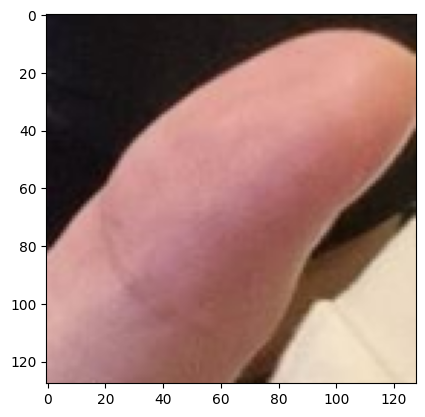

In [9]:
import matplotlib.pyplot as plt

plt.imshow(sample[0].permute(1, 2, 0).detach().cpu())

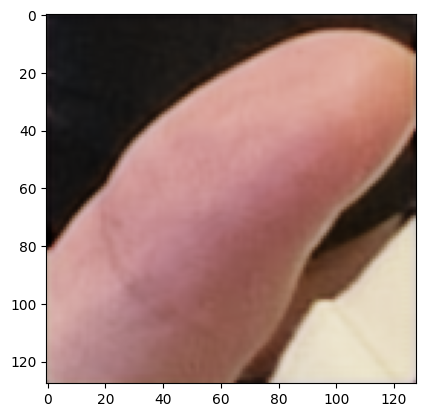

In [10]:
plt.imshow(reconstructed[0].permute(1, 2, 0).detach().cpu())

In [11]:
!pip install ultralytics

In [35]:
from ultralytics import YOLO

yolo = YOLO("best.pt")
predict = yolo.predict("KakaoTalk_20230802_011016785.jpg")


WARNING ⚠️ NMS time limit 0.550s exceeded
image 1/1 /content/drive/MyDrive/youngseok/sybi/KakaoTalk_20230802_011016785.jpg: 640x384 3 SYBI - v3 2023-12-10 6-03pms, 146.0ms
Speed: 7.8ms preprocess, 146.0ms inference, 960.4ms postprocess per image at shape (1, 3, 640, 384)


In [36]:
for result in predict:
    boxes = result.boxes  # Boxes object for bbox outputs
    masks = result.masks  # Masks object for segmentation masks outputs
    probs = result.probs  # Class probabilities for classification outputs

In [37]:
masks

In [195]:
segmentations = [
                [
                    285.18730937897067,
                    465.87426309669866
                ],
                [
                    251.09437974729423,
                    476.9915227592018
                ],
                [
                    225.1541072014537,
                    505.8963978817099
                ],
                [
                    228.9953040878808,
                    511.696347245232
                ],
                [
                    232.7248693010385,
                    570.6234776131232
                ],
                [
                    218.55252149103939,
                    628.8046949383829
                ],
                [
                    208.85565193682947,
                    699.6664339883786
                ],
                [
                    256.2824342564624,
                    714.1597288926021
                ],
                [
                    334.8444025381512,
                    711.9362769601014
                ],
                [
                    341.5147583356531,
                    666.726087665922
                ],
                [
                    347.4439634889881,
                    593.3521738934013
                ],
                [
                    345.22051155648757,
                    519.9782601208806
                ],
                [
                    329.65634802898313,
                    483.6618785567037
                ],
                [
                    313.35103385731185,
                    474.0269201825343
                ]
            ]

In [196]:
segmentations

[[285.18730937897067, 465.87426309669866],
 [251.09437974729423, 476.9915227592018],
 [225.1541072014537, 505.8963978817099],
 [228.9953040878808, 511.696347245232],
 [232.7248693010385, 570.6234776131232],
 [218.55252149103939, 628.8046949383829],
 [208.85565193682947, 699.6664339883786],
 [256.2824342564624, 714.1597288926021],
 [334.8444025381512, 711.9362769601014],
 [341.5147583356531, 666.726087665922],
 [347.4439634889881, 593.3521738934013],
 [345.22051155648757, 519.9782601208806],
 [329.65634802898313, 483.6618785567037],
 [313.35103385731185, 474.0269201825343]]

In [197]:
x_coord = [int(x) for x, y in segmentations]
y_coord = [int(y) for x, y in segmentations]

min_x, max_x = min(x_coord), max(x_coord)
min_y, max_y = min(y_coord), max(y_coord)

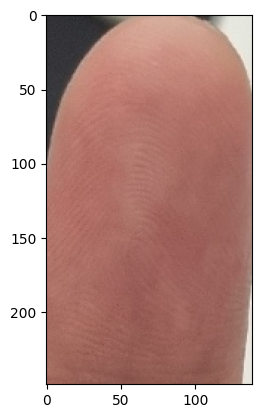

In [198]:
sample_img = np.array(Image.open('KakaoTalk_20230802_011016785.jpg'))[min_y:max_y, min_x:max_x, :]
plt.imshow(sample_img)

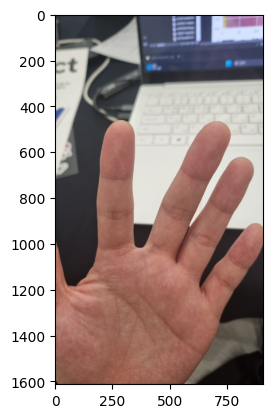

In [199]:
plt.imshow(np.array(Image.open('KakaoTalk_20230802_011016785.jpg')))

In [200]:
def enhance_fingerprint(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.equalizeHist(img)
    img = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 15, 2)
    ret, img = cv2.threshold(img, 90, 140, cv2.THRESH_BINARY)
    return img

In [209]:
segmentations = np.array(segmentations, dtype=np.int32)
sample_img = np.array(Image.open('KakaoTalk_20230802_011016785.jpg'))[min_y-10:max_y+20, min_x-20:max_x+20, :]
width, height, _ = sample_img.shape
mask = np.zeros(np.array(Image.open('KakaoTalk_20230802_011016785.jpg')).shape[:2], dtype=np.uint8)
mask = cv2.fillPoly(mask, [segmentations], 1)[min_y-10:max_y+20, min_x-20:max_x+20]

In [210]:
sample = test_transform(Image.fromarray(sample_img)).reshape(1, 3, 128, 128).to('cuda')

In [211]:
mask_resized = cv2.resize(mask, dsize=(128, 128), interpolation=cv2.INTER_CUBIC)
sample_img_resized = (sample[0].permute(1,2,0).detach().cpu().numpy() * 255).astype(np.uint8)

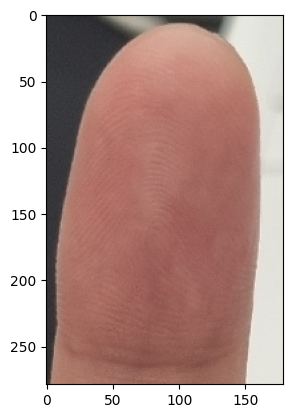

In [212]:
# plt.imshow((sample[0].permute(1, 2, 0).detach().cpu().numpy()*255).astype(np.uint8))
plt.imshow(sample_img)

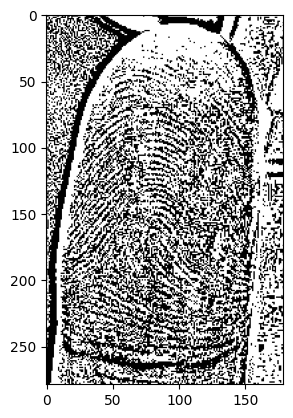

In [213]:
# plt.imshow(enhance_fingerprint((sample[0].permute(1, 2, 0).detach().cpu().numpy()*255).astype(np.uint8)))
plt.imshow(enhance_fingerprint(sample_img), cmap='gray')

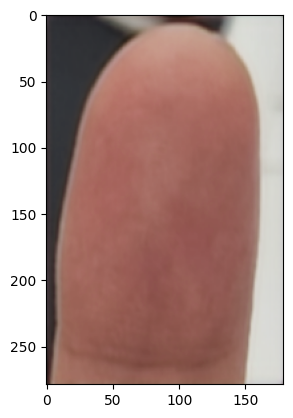

In [249]:
unet.eval()
unet_output = cv2.resize((unet(sample)[0].permute(1, 2, 0).detach().cpu().numpy()*255).astype(np.uint8), dsize=(height, width), interpolation=cv2.INTER_CUBIC)
hsvImg = cv2.cvtColor(unet_output,cv2.COLOR_BGR2HSV)

#multiple by a factor to change the saturation
hsvImg[...,1] = hsvImg[...,1]*1.05

#multiple by a factor of less than 1 to reduce the brightness
hsvImg[...,2] = hsvImg[...,2]*0.95

unet_output=cv2.cvtColor(hsvImg,cv2.COLOR_HSV2BGR)
plt.imshow(unet_output)

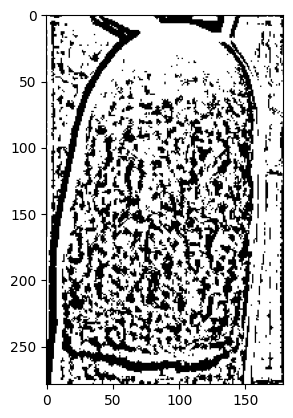

In [250]:
plt.imshow(enhance_fingerprint(unet_output), cmap='gray')

0.0023097991943359375


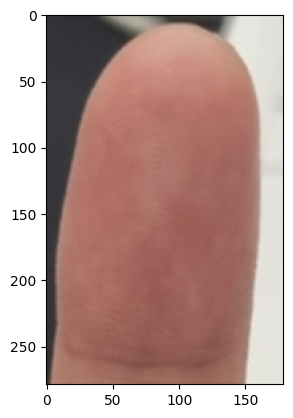

In [251]:
start = time.time()
gaussian = cv2.GaussianBlur(sample_img, (3,3), 3)
print(time.time() - start)
plt.imshow(gaussian)

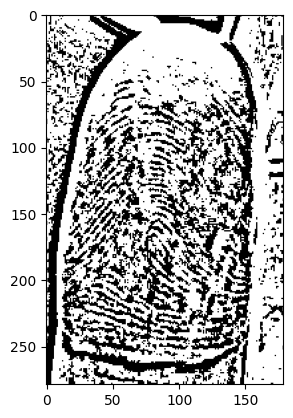

In [252]:
plt.imshow(enhance_fingerprint(gaussian), cmap='gray')

In [253]:
masked_img1 = mask * unet_output[:, :, 0]
masked_img2 = mask * unet_output[:, :, 1]
masked_img3 = mask * unet_output[:, :, 2]
output = cv2.merge((masked_img1, masked_img2, masked_img3))

mask_inv = mask ^ True
masked_img1 = mask_inv * sample_img[:, :, 0]
masked_img2 = mask_inv * sample_img[:, :, 1]
masked_img3 = mask_inv * sample_img[:, :, 2]
masked_img = cv2.merge((masked_img1, masked_img2, masked_img3))

output = np.add(masked_img.astype(np.uint8), output.astype(np.uint8)).astype(np.uint8)

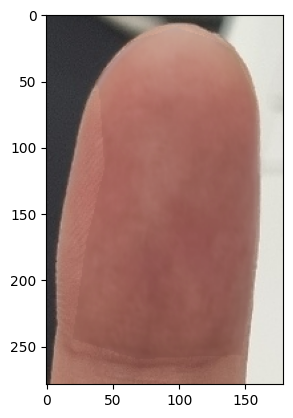

In [254]:
plt.imshow(output)

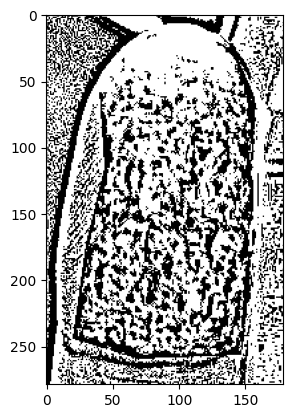

In [255]:
plt.imshow(enhance_fingerprint(output), cmap='gray')

In [256]:
masked_img1 = cv2.resize(cv2.resize(mask * sample_img[:, :, 0], (height // 2,width // 2)),(height,width))
masked_img2 = cv2.resize(cv2.resize(mask * sample_img[:, :, 1], (height // 2,width // 2)),(height,width))
masked_img3 = cv2.resize(cv2.resize(mask * sample_img[:, :, 2], (height // 2,width // 2)),(height,width))
output = cv2.merge((masked_img1, masked_img2, masked_img3))

mask_inv = mask ^ True
masked_img1 = mask_inv * sample_img[:, :, 0]
masked_img2 = mask_inv * sample_img[:, :, 1]
masked_img3 = mask_inv * sample_img[:, :, 2]
masked_img = cv2.merge((masked_img1, masked_img2, masked_img3))

output = np.add(masked_img.astype(np.uint8), output.astype(np.uint8)).astype(np.uint8)

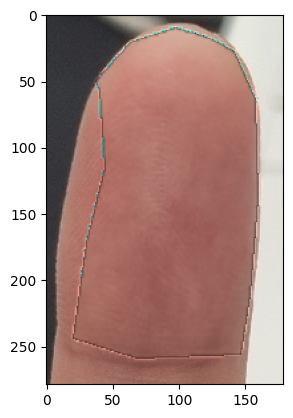

In [257]:
plt.imshow(output)

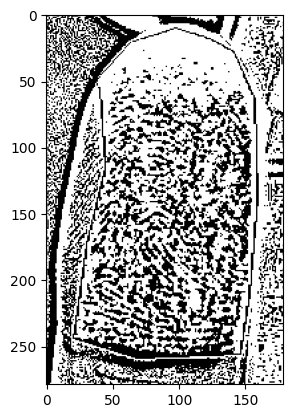

In [258]:
plt.imshow(enhance_fingerprint(output), cmap='gray')

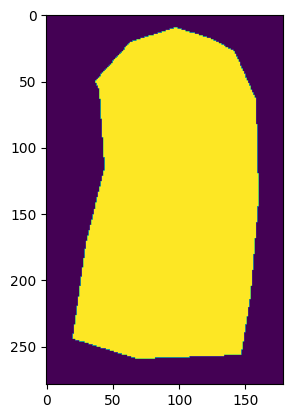

In [259]:
plt.imshow(mask)

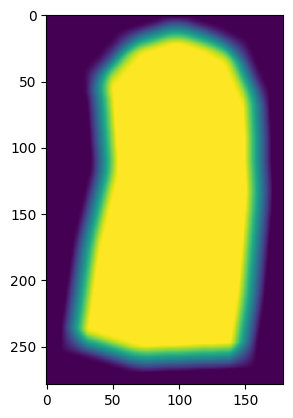

In [260]:
output_mask = cv2.blur(mask.astype(np.float32), (20, 20))
plt.imshow(output_mask)

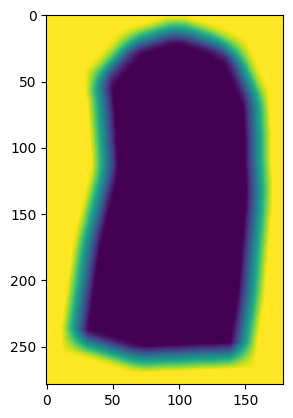

In [261]:
original_mask = np.ones((width, height)) - output_mask
plt.imshow(original_mask)

In [262]:
masked_img1 = output_mask * unet_output[:, :, 0]
masked_img2 = output_mask * unet_output[:, :, 1]
masked_img3 = output_mask * unet_output[:, :, 2]
output = cv2.merge((masked_img1, masked_img2, masked_img3))

masked_img1 = original_mask * sample_img[:, :, 0]
masked_img2 = original_mask * sample_img[:, :, 1]
masked_img3 = original_mask * sample_img[:, :, 2]
masked_img = cv2.merge((masked_img1, masked_img2, masked_img3))

output = np.add(masked_img, output).astype(np.uint8)

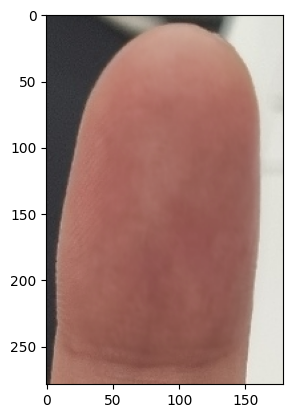

In [263]:
plt.imshow(output)

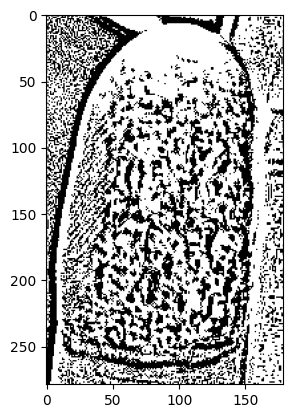

In [264]:
plt.imshow(enhance_fingerprint(output), cmap='gray')